In [146]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
from LRBv21 import LRBv21
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
from scipy import interpolate
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()
sepadd = 2
eqb = dict()

for side in ["iu", "ou"]:
    eqb[side] = dict()
    
    for design in designs:    
        eqb[side][design] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 500)

In [6]:
#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.05,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncKallenbachAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


In [148]:
study = dict()
store = study

for side in ["iu","ou"]:
    store[side] = dict()
    print("Side {}...".format(side))
    
    for design in ["SPR38"]:
        print("Design {}...".format(design))
        
        d = eqb[side][design].copy()
        constants = constants_default.copy()
        radios = radios_default.copy()

        radios["upstreamGrid"] = True
        constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
        constants["cz0"] = 0.1
        constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B
        
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10)
        indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
        
        # indexRange = [48]
        
        constants["Lfunc"] = LfuncKallenbachAr        
        out = LRBv21(constants,radios,d["S"],indexRange, 
                                            Ctol = 1e-3, Ttol = 1e-3, URF = 1, acceleration = 0, verbosity = 0,
                                            control_variable = "density")

        out["SpolPlot"] = [d["Spol"][x] for x in indexRange]
        
        store[side][design] = out

Side iu...
Design SPR38...
Solving...0...14...24...32...38...43...46...48...49...51...

C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Complete in 12.6 seconds
Side ou...
Design SPR38...
Solving...0...39...67...91...115...136...151...160...166...169...Complete in 12.4 seconds


- Known problem settings: SPR38, inner, index 48 at resolution 500, cz0 = 10%, qpllu0 = 1e9

# Iterate function

In [137]:
# Define iterator function. This just solves the Lengyel function and unpacks the results.
def iterate(cvar, Tu):
    if control_variable == "impurity_frac":
        cz = cvar
        nu = nu0
        qradial = qpllu0/np.abs(S[-1]-S[Xpoint]) # Change Q radial so it takes B field into account

    elif control_variable == "density":
        cz = cz0
        nu = cvar
        qradial = qpllu0/np.abs(S[-1]-S[Xpoint])   

    elif control_variable == "power":
        cz = cz0
        nu = nu0
        qradial = 1/cvar # This is needed so that too high a cvar gives positive error

    if verbosity>2:
        print(f"qpllu0: {qpllu0:.3E} | nu: {nu:.3E} | Tu: {Tu:.1f} | cz: {cz:.3E} | cvar: {cvar:.2E}", end = "")

    result = odeint(LengFunc,y0=[qpllt/B(s[0]),Tt],t=s,args=(kappa0,nu,Tu,cz,qpllu0,alpha,radios,S,B,Xpoint,Lfunc,qradial,qradial_fix))
    out = dict()
    # Result returns integrals of [dqoverBds, dtds]
    out["q"] = result[:,0]*B(s)
    out["T"] = result[:,1]
    out["Tu"] = out["T"][-1]
    Tucalc = out["Tu"]
    
    # Sometimes we get some negative q but ODEINT breaks down and makes upstream end positive.
    # If there are any negative values in the array, set the upstream q to the lowest value of q in array.
    # The algorithm will then know that it needs to go the other way
    if len(out["q"][out["q"]<0]) > 0:
        out["qpllu1"] = np.min(out["q"]) # minimum q
    else:
        out["qpllu1"] = out["q"][-1] # upstream q

    qpllu1 = out["qpllu1"]
    # If upstream grid, qpllu1 is at the midplane and is solved until it's 0. It then gets radial transport
    # so that the xpoint Q is qpllu0. If uypstramGrid=False, qpllu1 is solved to match qpllu0 at the Xpoint.
    if radios["upstreamGrid"]:
        out["error1"] = (out["qpllu1"]-0)/qpllu0 
    else:
        out["error1"] = (out["qpllu1"]-qpllu0)/qpllu0
        


    
    if verbosity > 2:
        print(f" -> qpllu1: {qpllu1:.3E} | Tucalc: {Tucalc:.1f} | error1: {out['error1']:.3E}")

    return out

# Lengfunc

In [138]:
def LengFunc(y,s,kappa0,nu,Tu,cz,qpllu0,alpha,radios,S,B,Xpoint,Lfunc,qradial, qradial_fix):

    qoverB,T = y
    #set density using constant pressure assumption
    ne = nu*Tu/T
    
    fieldValue = 0
    if s > S[-1]:
        fieldValue = B(S[-1])
    elif s < S[0]:
        fieldValue = B(S[0])
    else:
        fieldValue = B(s)
        
    # add a constant radial source of heat above the X point, which is qradial = qpll at Xpoint/np.abs(S[-1]-S[Xpoint]
    # i.e. radial heat entering SOL evenly spread between midplane and xpoint needs to be sufficient to get the 
    # correct qpll at the xpoint    
    if radios["upstreamGrid"]:
        if s >S[Xpoint]:
            # The second term here converts the x point qpar to a radial heat source acting between midplane and the xpoint
            if qradial_fix == True:
                try:
                    dqoverBds = ((nu**2*Tu**2)/T**2)*cz*Lfunc(T) - qradial * fieldValue / B(S[Xpoint]) # account for flux expansion to Xpoint
                except:
                    print("Failed. s: {:.2f}".format(s))
            else:
                dqoverBds = ((nu**2*Tu**2)/T**2)*cz*Lfunc(T) - qradial  
        else:
            dqoverBds = ((nu**2*Tu**2)/T**2)*cz*Lfunc(T) 
    else:
        dqoverBds = ((nu**2*Tu**2)/T**2)*cz*Lfunc(T) 
    
    # working on neutral/ionisation model
    dqoverBds = dqoverBds/fieldValue
    
    # Flux limiter
    dtds = 0
    if radios["fluxlim"]:
        dtds = qoverB*fieldValue/(kappa0*T**(5/2)-qoverB*fieldValue*kappa0*T**(1/2)/(alpha*ne*np.sqrt(9E-31)))
    else:
        dtds = qoverB*fieldValue/(kappa0*T**(5/2))
    #return gradient of q and T
    return [dqoverBds,dtds]

# Settings

In [139]:
S = d["S"]
verbosity = 3
control_variable = "density"
point = 48
timeout = 20
Ctol = 1e-3
Ttol = 1e-2
acceleration = 0
URF = 1.0
qradial_fix = True

t0 = timer()
C = []
radfraction = []
splot = []
error1 = 1
error0 = 1
output = defaultdict(list)

#lay out constants
gamma_sheath = constants["gamma_sheath"]
qpllu0 = constants["qpllu0"]
nu0 = constants["nu0"]
cz0 = constants["cz0"]
kappa0 = constants["kappa0"]
mi = constants["mi"]
echarge = constants["echarge"]
Tt = constants["Tt"]
Xpoint = constants["XpointIndex"]
B = constants["B"]
Lfunc = constants["Lfunc"]
alpha = constants["alpha"]

#initialise arrays for storing cooling curve data
Tcool = np.linspace(0.3,500,1000)#should be this for Ar? Ryoko 20201209 --> almost no effect
Lalpha = []
for dT in Tcool:
    Lalpha.append(Lfunc(dT))
Lalpha = np.array(Lalpha)
Tcool = np.append(0,Tcool)
Lalpha = np.append(0,Lalpha)
Lz = [Tcool,Lalpha]

# Calculation of radial heat transfer needed to achieve correct qpllu0 at Xpoint
qradial = qpllu0/np.abs(S[-1]-S[Xpoint])

print("Solving...", end = "")



Solving...

# Initialisation

In [140]:
print("{}...".format(point), end="")    

if verbosity > 0:
    print("\n---SOLVING FOR INDEX {}".format(point))

"""------INITIAL GUESSES"""

# Current set of parallel position coordinates
s = S[point:]
output["Splot"].append(S[point])

# Inital guess for the value of qpll integrated across connection length
qavLguess = 0
if radios["upstreamGrid"]:
    if s[0] < S[Xpoint]:
        qavLguess = ((qpllu0)*(S[Xpoint]-s[0]) + (qpllu0/2)*(s[-1]-S[Xpoint]))/(s[-1]-S[0])
    else:
        qavLguess = (qpllu0/2)
else:
    qavLguess = (qpllu0)

# Inital guess for upstream temperature based on guess of qpll ds integral
Tu0 = ((7/2)*qavLguess*(s[-1]-s[0])/kappa0)**(2/7)
Tu = Tu0

# Cooling curve integral
Lint = cumtrapz(Lz[1]*np.sqrt(Lz[0]),Lz[0],initial = 0)
integralinterp = interpolate.interp1d(Lz[0],Lint)

# Guesses/initialisations for control variables
if control_variable == "impurity_frac":
    # Initial guess of cz0 assuming qpll0 everywhere and qpll=0 at target
    # Initialise control variable as the impurity fraction guess
    cz0_guess = (qpllu0**2 )/(2*kappa0*nu0**2*Tu**2*integralinterp(Tu))
    cvar = cz0_guess

elif control_variable == "density":
    # Initialise control variable as the starting density
    # Impurity fraction is set to constant as cz0
    cvar = nu0

elif control_variable == "power":
    # If control variable = Power, keep nu0 and cz0 constant
    # Initialise control variable 1/qradial. This is needed so that
    # too high a cvar results in a positive error!
    cvar = 1/qradial #qpllu0

# Initial guess of qpllt, typically 0. This is a guess for q at the virtual
# target (cold end of front). It is a very rough approximation since we are assuming
# a sheath transmission coefficient (gamma) of a real target.
qpllt = gamma_sheath/2*nu0*Tu*echarge*np.sqrt(2*Tt*echarge/mi)

48...
---SOLVING FOR INDEX 48


# Solve

In [141]:
"""------INITIALISATION"""

log = defaultdict(list)
error1 = 1 # Inner loop error (error in qpllu based on provided cz/ne)
error0 = 1 # Outer loop residual in upstream temperature
log["error1"].append(error1)

# Tu convergence loop
for k0 in range(timeout):

    # Initialise
    out = iterate(cvar, Tu)
    reverse_search = False
    # if verbosity > 1:
    #     print("\ncvar: {:.3E}, error1: {:.3E}".format(cvar, out["error1"]))

    """------INITIAL SOLUTION BOUNDING"""

    # We are either doubling or halving cvar until the error flips sign
    log["cvar"].append(cvar)
    log["error1"].append(out["error1"])
    log["qpllu1"].append(out["qpllu1"])

    for k1 in range(timeout*2):
        if out["error1"] > 0:
            if reverse_search:
                cvar = cvar * 2
            else:
                cvar = cvar / 2

        elif out["error1"] < 0:
            if reverse_search:
                cvar = cvar / 2
            else:
                cvar = cvar * 2

        out = iterate(cvar, Tu)

        log["cvar"].append(cvar)
        log["error1"].append(out["error1"])
        log["qpllu1"].append(out["qpllu1"])

#         if verbosity > 1:
#             print("cvar: {:.3E}, error1: {:.3E}".format(cvar, out["error1"]))

#         if verbosity > 2:
#             print("Last error: {:.3E}, New error: {:.3E}".format(log["error1"][k1+1], log["error1"][k1+2]))

        if np.sign(log["error1"][k1+1]) != np.sign(log["error1"][k1+2]): # It's initialised with a 1 already, hence k1+1 and k1+2
            break

        if k1 == timeout - 1:
            print("******INITIAL BOUNDING TIMEOUT! Saturation!. Set verbosity = 3!*******")
            print(f"qpllu0: {qpllu0} | qpllu1: {qpllu1}")
            # cvar = log["cvar"][0]
            # reverse_search = True
            # sys.exit()

    if cvar < 1e-6 and control_variable == "impurity_fraction":
        print("*****REQUIRED IMPURITY FRACTION IS NEAR ZERO*******")
        #sys.exit()

    # We have bounded the problem -  the last two iterations
    # are on either side of the solution
    lower_bound = min(log["cvar"][-1], log["cvar"][-2])
    upper_bound = max(log["cvar"][-1], log["cvar"][-2])

    lower_error = log["error1"][log["cvar"].index(lower_bound)+1]
    upper_error = log["error1"][log["cvar"].index(upper_bound)+1]

    """------INNER LOOP"""

    for k2 in range(timeout):

        # New cvar guess is halfway between the upper and lower bound.
        cvar = lower_bound + (upper_bound-lower_bound)/2
        out = iterate(cvar, Tu)
        log["cvar"].append(cvar)
        log["error1"].append(out["error1"])
        log["qpllu1"].append(out["qpllu1"])

        # Narrow bounds based on the results.
        if out["error1"] < 0:
            lower_bound = cvar
        elif out["error1"] > 0:
            upper_bound = cvar

        if verbosity > 1:
            print(">Bounds: {:.3E}-{:.3E}, cvar: {:.3E}, error1: {:.3E}".format(
                lower_bound, upper_bound, cvar, out["error1"]))

        if abs(out["error1"]) < Ctol:
            break

        if k2 == timeout - 1:
            print("******INNER LOOP TIMEOUT! Reduce acceleration factor or loosen Ctol. Set verbosity = 2!*******")
            #sys.exit()

    # Calculate the new Tu by mixing half the old and half the new value.
    Tucalc = out["Tu"]
    Tu = (1-URF)*Tu + URF*Tucalc
    error0 = (Tu-Tucalc)/Tu

    if verbosity > 0 :
        print("-----------error0: {:.3E}, Tu: {:.2f}, Tucalc: {:.2f}".format(error0, Tu, Tucalc))


    log["Tu"].append(Tu)
    log["error0"].append(error0)


    if abs(error0) < Ttol:
        break

    if k0 == timeout - 1:
        print("******OUTER TIMEOUT! Loosen Ttol or reduce under-relaxation factor. Set verbosity = 2!*******")
        #sys.exit()


if control_variable == "power":
    output["cvar"].append(1/cvar) # so that output is in Wm-2
else:
    output["cvar"].append(cvar)

output["Tprofiles"].append(out["T"])
output["Sprofiles"].append(s)
output["Qprofiles"].append(out["q"])

Qrad = []
for Tf in out["T"]:
    if control_variable == "impurity_frac":
        Qrad.append(((nu0**2*Tu**2)/Tf**2)*cvar*Lfunc(Tf))
    elif control_variable == "density":
        Qrad.append(((cvar**2*Tu**2)/Tf**2)*cz0*Lfunc(Tf))
    elif control_variable == "power":
        Qrad.append(((nu0**2*Tu**2)/Tf**2)*cz0*Lfunc(Tf))

output["Rprofiles"].append(Qrad)
output["logs"].append(log)

qpllu0: 1.000E+09 | nu: 1.000E+20 | Tu: 144.7 | cz: 1.000E-01 | cvar: 1.00E+20 -> qpllu1: 3.403E+09 | Tucalc: 242.8 | error1: 3.403E+00
qpllu0: 1.000E+09 | nu: 5.000E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 5.00E+19 -> qpllu1: 4.234E+08 | Tucalc: 169.9 | error1: 4.234E-01
qpllu0: 1.000E+09 | nu: 2.500E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 2.50E+19

C:\Users\Mike\AppData\Local\Temp/ipykernel_2308/1665746766.py:41: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 -> qpllu1: NAN | Tucalc: 242.8 | error1: NAN
qpllu0: 1.000E+09 | nu: 3.750E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 3.75E+19 -> qpllu1: -2.135E+08 | Tucalc: 136.0 | error1: -2.135E-01
>Bounds: 3.750E+19-5.000E+19, cvar: 3.750E+19, error1: -2.135E-01
qpllu0: 1.000E+09 | nu: 4.375E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 4.38E+19 -> qpllu1: 9.871E+07 | Tucalc: 155.0 | error1: 9.871E-02
>Bounds: 3.750E+19-4.375E+19, cvar: 4.375E+19, error1: 9.871E-02
qpllu0: 1.000E+09 | nu: 4.062E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 4.06E+19 -> qpllu1: -5.902E+07 | Tucalc: 146.2 | error1: -5.902E-02
>Bounds: 4.062E+19-4.375E+19, cvar: 4.062E+19, error1: -5.902E-02
qpllu0: 1.000E+09 | nu: 4.219E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 4.22E+19 -> qpllu1: 1.945E+07 | Tucalc: 150.7 | error1: 1.945E-02
>Bounds: 4.062E+19-4.219E+19, cvar: 4.219E+19, error1: 1.945E-02
qpllu0: 1.000E+09 | nu: 4.141E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 4.14E+19 -> qpllu1: -1.989E+07 | Tucalc: 148.5 | error1: -1.989E-02
>Bound

# Result plot

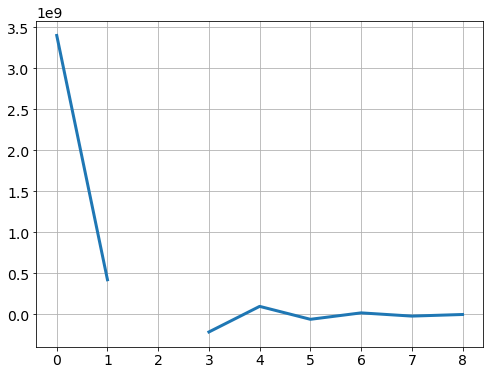

In [142]:
plt.plot(log["qpllu1"])

# Test iteration

qpllu0: 1.000E+09 | nu: 1.000E+20 | Tu: 144.7 | cz: 1.000E-01 | cvar: 1.00E+20 -> qpllu1: 3.402E+09 | Tucalc: 242.8 | error1: 3.402E+00
qpllu0: 1.000E+09 | nu: 5.000E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 5.00E+19 -> qpllu1: 4.230E+08 | Tucalc: 169.9 | error1: 4.230E-01
qpllu0: 1.000E+09 | nu: 2.500E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 2.50E+19

C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 -> qpllu1: -6.793E+08 | Tucalc: 43.0 | error1: -6.793E-01
qpllu0: 1.000E+09 | nu: 1.250E+19 | Tu: 144.7 | cz: 1.000E-01 | cvar: 1.25E+19 -> qpllu1: NAN | Tucalc: 242.8 | error1: NAN


C:\Users\Mike\AppData\Local\Temp/ipykernel_2308/1665746766.py:41: RuntimeWarning: invalid value encountered in double_scalars
  dtds = qoverB*fieldValue/(kappa0*T**(5/2))
C:\Apps\Anaconda3\envs\py38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


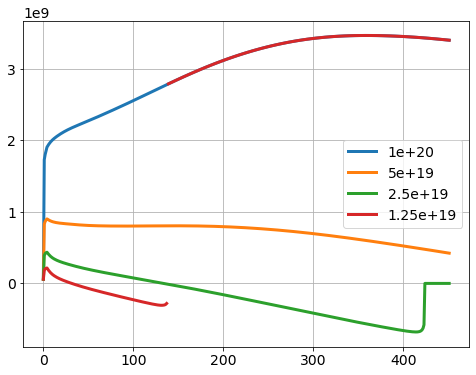

In [144]:
for i in [1e20, 5e19, 2.5e19,  1.25e19]:
# for i in [5e19, 4.0e19]:

    test = iterate(i, 144.7)

    plt.plot(test["q"], label = i)
    
plt.legend()

In [136]:
- ODEINT starts at 1e20. The algorithm halves the density in the hope of getting a negative error
- Somehow ODEINT messes up and allows a negative q while maintaining a positive q near the midplane
- Since the error is the deviation of the upstream q from 0 

43